#Data augmentation & Pneumonia Detection

Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as bleeding, lung cancer, or surgical changes. 
\
A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR. 

In this notebook, we study pneumonia detection and the effect of data augmentation on our performances.

The notebook was run on kaggle with the X-ray pneumonia detection dataset.

##Import Libraries and data directories

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import glob
from tqdm.notebook import tqdm

import albumentations as A

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense, SeparableConv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import random, choice, shuffle
from PIL import Image

In [ ]:
train_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

In [ ]:
print("Train data has "+str(len(train_data)) + " images")
print("Validation data has "+str(len(val_data)) + " images")
print("Test data has "+str(len(test_data)) + " images")

Train data has 5216 images
Validation data has 16 images
Test data has 624 images


## Exploratory data analysis

### Datasets' distribution

We visualize the number of normal and pneumonia images.

In [ ]:
# extract number of normal and pneumonia cases
DIR = "../input/chest-xray-pneumonia/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

#create list of all images paths
for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


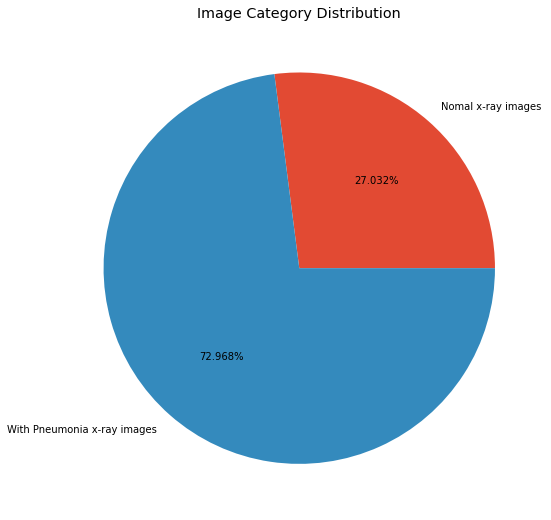

In [ ]:
labels = ['Nomal x-ray images', 'With Pneumonia x-ray images']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.3f%%")
plt.title("Image Category Distribution")
plt.show()

The data contains more Pneumia x-Ray images than normal x-Ray images.

In [ ]:
# Shuffle and Get some images into new list
shuffle(all_normal)
shuffle(all_pneumonia)
all_images = all_normal[:20] + all_pneumonia[:20]

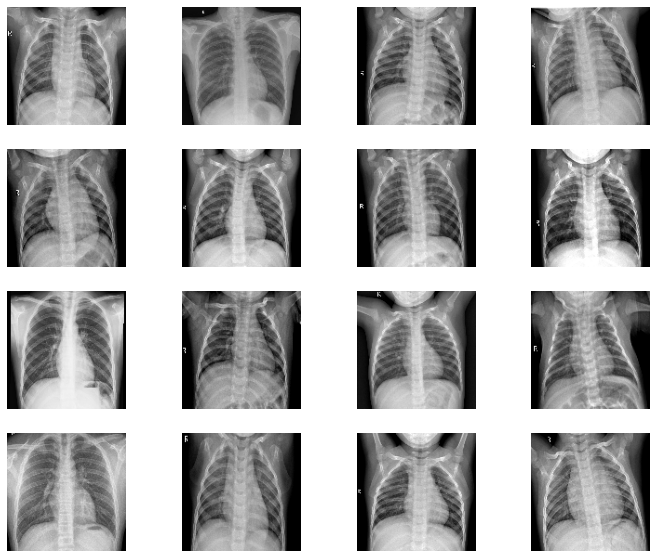

In [ ]:
fig=plt.figure(figsize=(12, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(all_images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [ ]:
#About training set 

DIR = "../input/chest-xray-pneumonia/chest_xray/train"
all_train = []
norm = glob.glob(os.path.join(DIR, "NORMAL/*.jpeg"))
pneu = glob.glob(os.path.join(DIR, "PNEUMONIA/*.jpeg"))
all_train.extend(norm)
all_train.extend(pneu)

print(f"Total Pneumonia train Images: {len(pneu)}")
print(f"Total Normal train Images: {len(norm)}")

Total Pneumonia train Images: 3875
Total Normal train Images: 1341


The data is imbalanced. We can tackle this problem problem later by using the weighted loss function to optimize when creating our deep learning model.


### HSV
We tried to raise saturation and value (S and V components of the
HSV color space) of all pixels to a power between 0.25 and 4 (same
for all pixels within a patch), multiply these values by a factor
between 0.7 and 1.4, and add to them a value between -0.1 and 0.1.
Also, you could add a value between [-0.1, 0.1] to the hue (H
component of HSV) of all pixels in the image/patch.

### Gaussian blur 

Also known as Gaussian smoothing is the result of blurring an image by a Gaussian function.
We used it to reduce image noise and reduce detail. The visual effect of this blurring technique is a smooth blur resembling that of viewing the image through a translucent screen

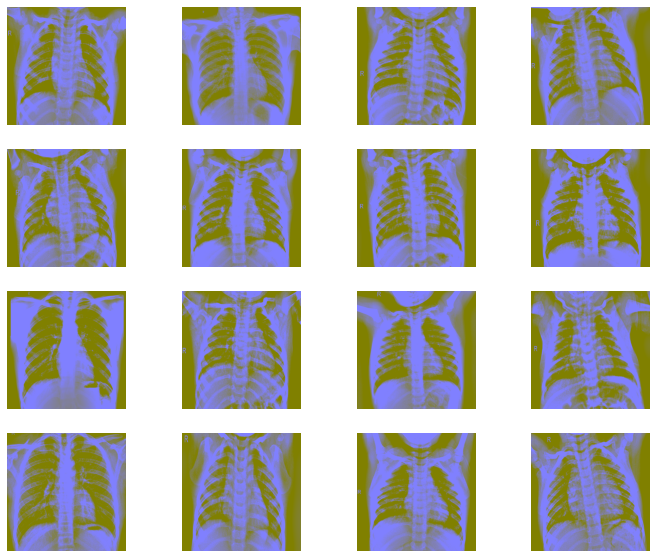

In [ ]:
fig=plt.figure(figsize=(12, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(all_normal[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)                                     #HSV 
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)  # Gaussian Blur
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

### Albumentations for data augmentation 


**Light** : RandomSunFlare, RandomFog, RandomBrightness

**Position** : Rotate, HorizontalFlip, VerticalFlip

**Color shifting**: RGBShift, HVS, RandomContrast




In [ ]:
#Fonction that returns augmented images and can plot them
def plot_multiple_img(images,image_index,Albumentations, ncols, main_title="",plot=False):
    
    if plot==True: 
        fig, myaxes = plt.subplots(figsize=(20, 12), nrows=2, ncols=ncols, squeeze=False)
        fig.suptitle(main_title, fontsize = 30)
        fig.subplots_adjust(wspace=0.3)
        fig.subplots_adjust(hspace=0.3)
        img_matrix_list=[]  #Plot augmented image if we stet the boolean variable to TRUE
    
    image=cv2.imread(images[image_index])
    images=[]
    i=0
    for alb in (Albumentations.keys()): # iterate through Albumentations dictionnary {name of alb: alb}
        trans=Albumentations[alb]
        img=trans(image=image)['image']
        images.append(img)
        
        if plot==True: # plot albumentations if plot is activated
            myaxes[i // ncols][i % ncols].imshow(img)
            myaxes[i // ncols][i % ncols].set_title(alb, fontsize=15)
            i+=1
    plt.show()
    return(images) #return images with data augmentation

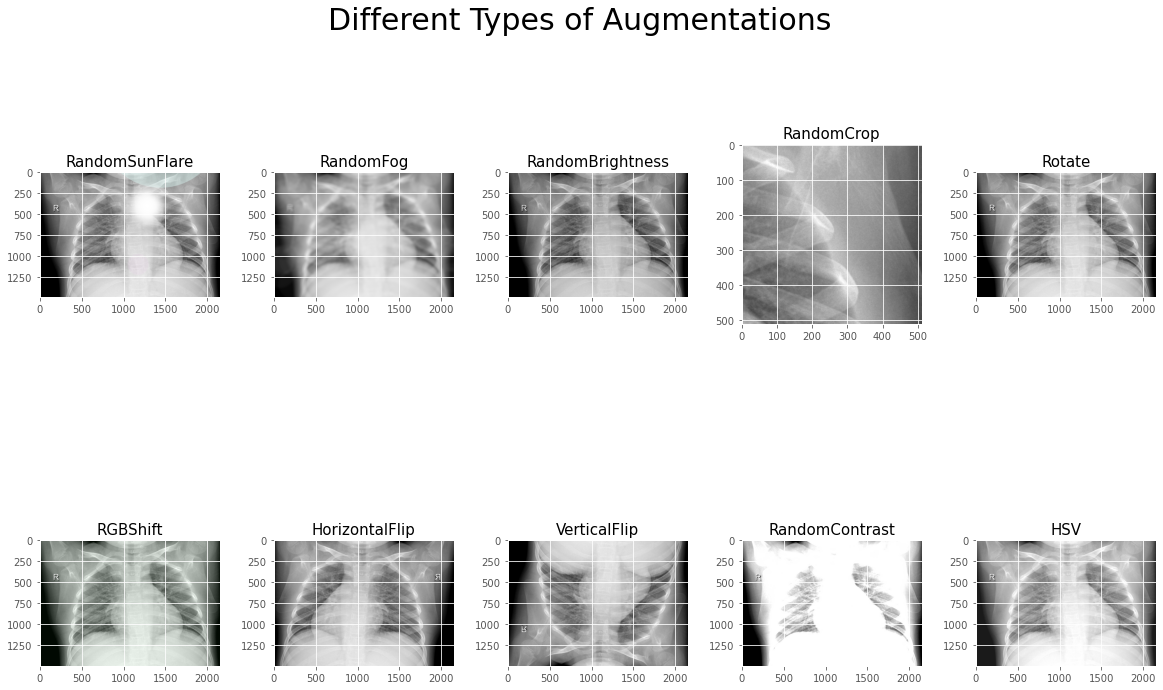

In [ ]:
Albumentations = dict()

# transformation parameters
theta = 0.3
hrz_shift = 40
ver_shift = 40
size_low = 0.8
size_high = 1.3
cont_low = 0.7
cont_high = 1.3
rgb_limit=10



albs_keys=["RandomSunFlare","RandomFog","RandomBrightness",
               "RandomCrop","Rotate", "RGBShift","HorizontalFlip", "VerticalFlip", 
                     "RandomContrast","HSV"]

albs_values = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                A.RandomCrop(p=1,height = 512, width = 512), A.Rotate(p=1, limit=theta),
                A.RGBShift(r_shift_limit=rgb_limit,g_shift_limit=rgb_limit, b_shift_limit=rgb_limit,p=1),
                A.HorizontalFlip(p=1), A.VerticalFlip(p=1), 
                A.RandomContrast(limit = [cont_low, cont_high],p = 1),
                A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]
#plot the Albumentations
for i in range(len(albs_keys)):
    Albumentations[albs_keys[i]]=albs_values[i]
cc=plot_multiple_img(all_images,19,Albumentations, ncols = 5,main_title="Different Types of Augmentations",plot=True)

1. The random sun flare is not intresting. 
2. Random Fog also adds so much noise to our data. 
3. Random Brightness may give more diversity to our data that may help the model if their value is not relatively high (not causing too much change to data). 
4. The random crop is interesting because it gives us realistic variations if the postions of the scan as long as the crop value is small. 
5. Rotate is an interesting technique because not all patients will have the same position or even the exact same chest. It's better keep it. 
6. Using RGBShift, some information may be lost by shifting (location of pneumonia). 
7. HorizontalFlip and Vertical flip don't really add information. 
8. Random Contrast may be interesting with other fixed parameters or applied with Random Brightness. 
9. Varying saturation and value HVS is an interesting method that may highlight the pneumonia location.    


In [ ]:
Albumentations = dict()

# transformations' parameters
theta = 0.3
size_low = 0.8
size_high = 1.3
bright_limit = 0.1
cont_limit = 0.1
rgb_limit=10



albs_keys=["RandomResizedCrop",
           "Rotate",
    "RandomBrightnessContrast",
           "HSV"]

albs_values = [ 
                A.RandomResizedCrop (p=1,height=256, width=256,scale=[0.95,0.95]),  #height after crop and resize#width after crop and resize#range of size of the origin size cropped
                A.Rotate(p=1, limit=theta), #thata rotation
                A.RandomBrightnessContrast(brightness_limit = [-bright_limit, bright_limit], 
                                           contrast_limit= [-cont_limit, cont_limit],p = 1), #factor range for changing brightness#contrast_limit:factor range for changing contrast
                A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)] #range for changing hue #range for changing saturation#range for changing value

for i in range(len(albs_keys)):
    Albumentations[albs_keys[i]]=albs_values[i]




Here we visualize the four transformations we've chosen.

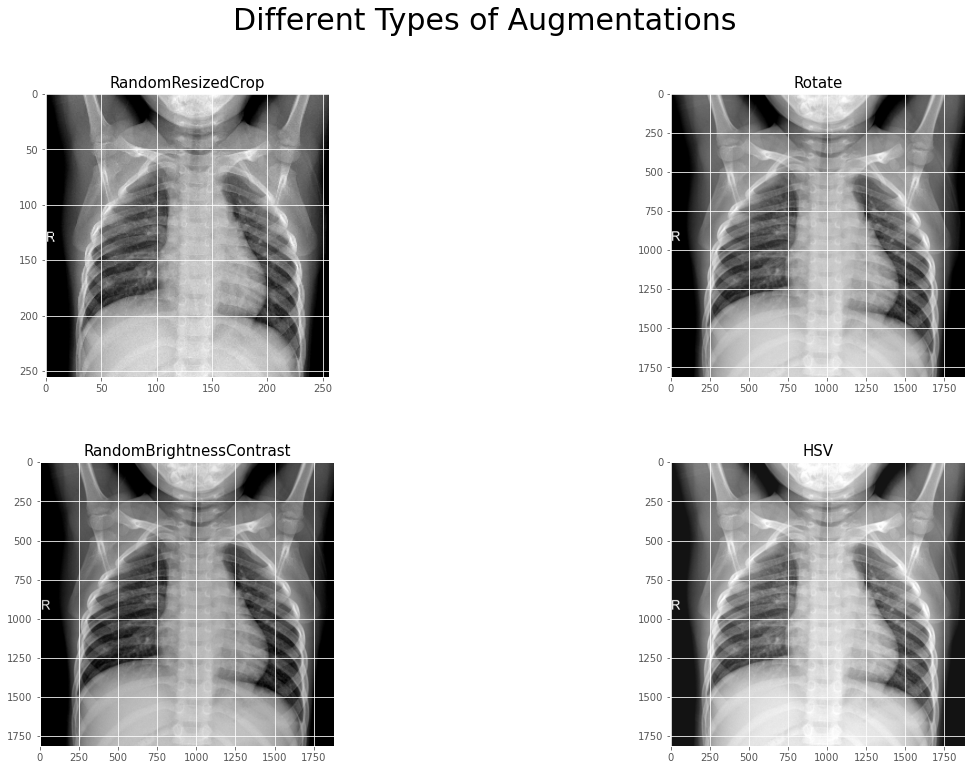

In [ ]:
cc=plot_multiple_img(all_images,15,Albumentations, ncols =2 ,main_title="Different Types of Augmentations",plot=True)

## Data Preperation

We copy the data from the kaggle input so that we can manipulate the images and apply preprocessing.

In [ ]:
from distutils.dir_util import copy_tree
fromDirectory="../input"
toDirectory="./"
copy_tree(fromDirectory, toDirectory)

['./chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg',
 './chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg',
 './chest-x

### Preparing data for training
1-Resizing the images.

2-Putting all images in the same format. 

In [ ]:
train_data = glob.glob('./chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('./chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('./chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

In [ ]:
#input image resolution
res = 256
def preprocess(train_data):
    for x in train_data:
        img=cv2.imread(x)
        img_res=cv2.resize(img,(res,res)) #resizing 
        final_image=Image.fromarray(img_res)
        final_image.save(x)

In [ ]:
preprocess(train_data)
preprocess(val_data)
preprocess(test_data)

We define the function 'aug' that applies a random transformation from those we've chosen on our training data.

In [ ]:
# function to apply augmentation on train_data and add augmented data to directory
def aug(train_pro):
    all_train_augment=[]
    for i in range(len(train_pro)) :
        #choose only about 25% of the images to apply augmentation to avoid overfitting or large computation
        n=random()
        if (n>0.75):
            #Apply one random function on an img 
            j=choice(list(Albumentations.keys()))
            d=dict()
            d[j]=Albumentations[j]
            #image=cv2.imread(train_pro[i])
            aug_image=plot_multiple_img(train_pro,i,d, ncols =1 ,main_title="",plot=False)[0]
            print(d[j])
            final_image=Image.fromarray(aug_image)
            aug_direc=train_pro[i][:-5]+"_augmented"+train_pro[i][-5:]
            final_image.save(aug_direc)


In [ ]:
#don't apply augmentation
augmentaion=False
if augmentaion==True:
    aug(train_data)

### Preparing data for the model using ImageDataGenerator 

Since validation_data contains onlt 16 images, we will use the test_data as our validation data when training the neural network.

In [ ]:
#create data generators
train_generator = ImageDataGenerator(rescale=1/255.)  
#val_generator = ImageDataGenerator(rescale=1/255.)
test_generator = ImageDataGenerator(rescale=1/255.)
#iterate data into generator and convert it to tensorflow data
train_data = train_generator.flow_from_directory(directory="./chest-xray-pneumonia/chest_xray/train",
                                                 target_size=(256, 256),batch_size=16,
                                                class_mode='binary')

#validation_data = val_generator.flow_from_directory(directory="./chest-xray-pneumonia/chest_xray/val",target_size=(256, 256), batch_size=1,class_mode='binary')

test_data = test_generator.flow_from_directory(directory="./chest-xray-pneumonia/chest_xray/test", 
                                                 target_size=(256, 256), batch_size=8,
                                              class_mode='binary')


Found 6558 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
#For original data: 
len_train = len(glob.glob('./chest-xray-pneumonia/chest_xray/train/**/*.jpeg'))
len_train_normal = len(glob.glob('./chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg'))
len_train_pneumonia = len(glob.glob('./chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg'))
len_validation = len(glob.glob('./chest-xray-pneumonia/chest_xray/val/**/*.jpeg'))
len_validation_normal = len(glob.glob('./chest-xray-pneumonia/chest_xray/val/NORMAL/*.jpeg'))
len_validation_pneumonia = len(glob.glob('./chest-xray-pneumonia/chest_xray/val/PNEUMONIA/*.jpeg'))
len_test = len(glob.glob('./chest-xray-pneumonia/chest_xray/test/**/*.jpeg'))
len_test_normal = len(glob.glob('./chest-xray-pneumonia/chest_xray/test/NORMAL/*.jpeg'))
len_test_pneumonia = len(glob.glob('./chest-xray-pneumonia/chest_xray/test/PNEUMONIA/*.jpeg'))

In [ ]:
#Predefine model blocks:
def conv_block(filters, name):
    block = Sequential([
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ], name=name)
    return block

def dense_block(units, dropout_rate, name):
    block = Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ], name=name)
    return block

## Modelling
### Building the model

In [ ]:
def build_model(input_size=256, num_filters=16):
    model=Sequential()
    model.add(Conv2D(filters=num_filters, kernel_size=(3,3), input_shape=(input_size, input_size, 3), 
    padding='same',  name="conv2d_0"))
    model.add(Conv2D(filters=num_filters, kernel_size=(3,3), input_shape=(input_size, input_size, 3), 
    padding='same',  name="conv2d_1"))
    model.add(MaxPool2D(name="maxpool2d_0"))

    model.add(conv_block(filters=num_filters*2, name="convblock_0"))

    model.add(conv_block(filters=num_filters*4, name="convblock_1")) 
                     

    model.add(conv_block(filters=num_filters*8, name="convblock_2"))
                     

    model.add(Dropout(rate=0.2, name="dropout_0"))
                    

    model.add(conv_block(filters=num_filters*16, name="convblock_3"))

    model.add(Dropout(rate=0.2, name="dropout_1"))

    num_units=num_filters
    model.add(Flatten(name="flatten_0")) 
    model.add(dense_block(units=num_units*32, dropout_rate=0.7, name="denseblock_0"))
                     
    model.add(dense_block(units=num_units*8, dropout_rate=0.5, name="denseblock_1"))
    model.add(dense_block(units=num_units*4, dropout_rate=0.3, name="denseblock_2"))
                     

    model.add(Dense(units=1, activation='sigmoid', name="output_layer"))
    return(model)


In [ ]:
#Weighting the data to make it more balanced 
w0 = len_train/(2*len_train_normal) #weight for pneumonia
w1 = len_train/(2*len_train_pneumonia) #weight for normal

classes=np.array(['NORMAL', 'PNEUMONIA'])
metrics = ['accuracy',"Precision", "Recall"] #metrics to use while training (on train and validation)
batch_size= 16 
epochs = 25
steps_per_epoch = len_train // batch_size

#create check point callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

#we can activate his option for early stopping to stop when the model starts overfitting or the model becomes stagnant
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#controlling the learning rate decay  
def scheduler(s, lr):
    return (lambda epoch: lr * (0.1)**(epoch/s))
lr_decay_fn=scheduler(20, 0.01)
scheduler=tf.keras.callbacks.LearningRateScheduler(lr_decay_fn)

model = build_model()
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)


### Model Summary

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_0 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
maxpool2d_0 (MaxPooling2D)   (None, 128, 128, 16)      0         
_________________________________________________________________
convblock_0 (Sequential)     (None, 64, 64, 32)        2160      
_________________________________________________________________
convblock_1 (Sequential)     (None, 32, 32, 64)        7392      
_________________________________________________________________
convblock_2 (Sequential)     (None, 16, 16, 128)       27072     
_________________________________________________________________
dropout_0 (Dropout)          (None, 16, 16, 128)      

In [ ]:
hist = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_data,
    validation_steps=len_test // batch_size,
    class_weight={0: w0, 1: w1},
    callbacks=[checkpoint_callback, scheduler],
)

Epoch 1/25
409/409 [==============================] - 44s 107ms/step - loss: 0.4822 - accuracy: 0.7628 - precision: 0.9135 - recall: 0.7519 - val_loss: 0.5343 - val_accuracy: 0.7564 - val_precision: 0.8367 - val_recall: 0.7885
Epoch 2/25
409/409 [==============================] - 43s 104ms/step - loss: 0.2883 - accuracy: 0.8806 - precision: 0.9595 - recall: 0.8764 - val_loss: 0.8064 - val_accuracy: 0.7981 - val_precision: 0.7729 - val_recall: 0.9953
Epoch 3/25
409/409 [==============================] - 43s 106ms/step - loss: 0.2186 - accuracy: 0.9123 - precision: 0.9731 - recall: 0.9071 - val_loss: 0.4290 - val_accuracy: 0.8173 - val_precision: 0.9650 - val_recall: 0.7263
Epoch 4/25
409/409 [==============================] - 43s 105ms/step - loss: 0.2008 - accuracy: 0.9211 - precision: 0.9768 - recall: 0.9157 - val_loss: 0.4237 - val_accuracy: 0.8429 - val_precision: 0.8190 - val_recall: 0.9645
Epoch 5/25
409/409 [==============================] - 43s 105ms/step - loss: 0.1827 - accura

In [ ]:
################################################################################################################################################
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])

### Performance of the model trained on original data

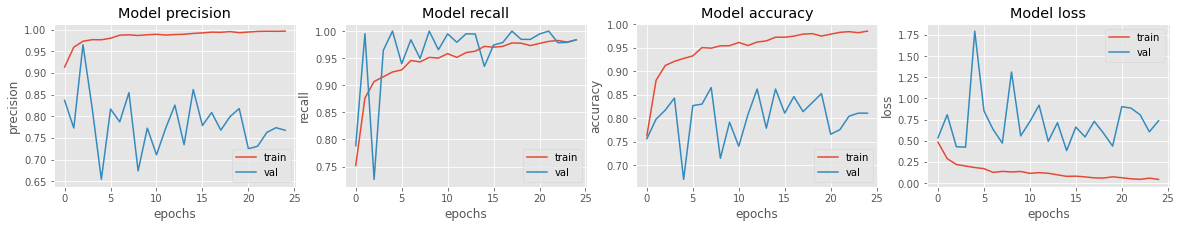

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

The model is doing quite well. Performance (precision & accuracy) on the val dataset is not as good as for the train. The cause may be overfitting. Using data augmentation may solve the problem by helping data generalize better.

##Effect of data augmentation

The same previous steps are repeated. The only change is the data augmentation before preprocessing

In [ ]:
train_data = glob.glob('./chest-xray-pneumonia/chest_xray/train/**/*.jpeg')

In [ ]:
aug(train_data)

RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
HueSaturationV

RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(alwa

RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedC

Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast

HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolat

RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_

Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
R

Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1

Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
Rotate(always_apply=False, 

HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_

Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_a

RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limi

Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95,

HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomBr

RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.3333333333333333), interpolation=1)
Rotate(always_apply=False, p=1, limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-50, 50))
RandomResizedCrop(always_apply=False, p=1, height=256, width=256, scale=[0.95, 0.95], ratio=(0.75, 1.33

In [ ]:
  
train_data_aug = glob.glob('./chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data_aug = glob.glob('./chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data_aug = glob.glob('./chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

#create data generators
train_generator = ImageDataGenerator(rescale=1/255.)
val_generator = ImageDataGenerator(rescale=1/255.)
test_generator = ImageDataGenerator(rescale=1/255.)
#import data into generator and convert it to tensorflow data
train_data_aug = train_generator.flow_from_directory(directory="./chest-xray-pneumonia/chest_xray/train",
                                                 target_size=(256, 256),batch_size=16,
                                                class_mode='binary')

validation_data_aug = val_generator.flow_from_directory(directory="./chest-xray-pneumonia/chest_xray/val", 
                                                 target_size=(256, 256), batch_size=1,
                                                    class_mode='binary')

test_data_aug = test_generator.flow_from_directory(directory="./chest-xray-pneumonia/chest_xray/test", 
                                                 target_size=(256, 256), batch_size=8,
                                              class_mode='binary')

len_train_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/train/**/*.jpeg'))
len_train_normal_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg'))
len_train_pneumonia_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg'))
len_validation_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/val/**/*.jpeg'))
len_validation_normal_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/val/NORMAL/*.jpeg'))
len_validation_pneumonia_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/val/PNEUMONIA/*.jpeg'))
len_test_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/test/**/*.jpeg'))
len_test_normal_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/test/NORMAL/*.jpeg'))
len_test_pneumonia_aug = len(glob.glob('./chest-xray-pneumonia/chest_xray/test/PNEUMONIA/*.jpeg'))

w0 = len_train_aug/(2*len_train_normal_aug) #weight for pneumonia
w1 = len_train_aug/(2*len_train_pneumonia_aug) #weight for normal

classes=np.array(['NORMAL', 'PNEUMONIA'])
metrics = ['accuracy',"Precision", "Recall"]
batch_size= 16 
epochs = 25
steps_per_epoch = len_train_aug // batch_size

#create check point callback
checkpoint_callback_aug = tf.keras.callbacks.ModelCheckpoint("xray_model_aug.h5", save_best_only=True)

#stops when the model starts overfitting or the model becomes stagnant
#early_stopping_callback_aug = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

def scheduler(s, lr):
    return (lambda epoch: lr * (0.1)**(epoch/s))
lr_decay_fn=scheduler(20, 0.01)
scheduler_aug=tf.keras.callbacks.LearningRateScheduler(lr_decay_fn)

model_aug = build_model()
    
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)


Found 7814 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model_aug.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_0 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
maxpool2d_0 (MaxPooling2D)   (None, 128, 128, 16)      0         
_________________________________________________________________
convblock_0 (Sequential)     (None, 64, 64, 32)        2160      
_________________________________________________________________
convblock_1 (Sequential)     (None, 32, 32, 64)        7392      
_________________________________________________________________
convblock_2 (Sequential)     (None, 16, 16, 128)       27072     
_________________________________________________________________
dropout_0 (Dropout)          (None, 16, 16, 128)      

In [ ]:
hist_aug = model_aug.fit(
    train_data_aug,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_data_aug,
    validation_steps=len_test_aug // batch_size,
    class_weight={0: w0, 1: w1},
    callbacks=[checkpoint_callback_aug, scheduler_aug],
)

Epoch 1/25
488/488 [==============================] - 53s 108ms/step - loss: 0.3863 - accuracy: 0.8287 - precision: 0.9391 - recall: 0.8233 - val_loss: 0.5259 - val_accuracy: 0.7756 - val_precision: 0.7657 - val_recall: 0.9289
Epoch 2/25
488/488 [==============================] - 50s 103ms/step - loss: 0.2375 - accuracy: 0.9068 - precision: 0.9695 - recall: 0.9033 - val_loss: 2.2024 - val_accuracy: 0.6346 - val_precision: 0.6346 - val_recall: 1.0000
Epoch 3/25
488/488 [==============================] - 50s 103ms/step - loss: 0.2462 - accuracy: 0.9028 - precision: 0.9706 - recall: 0.8967 - val_loss: 0.7593 - val_accuracy: 0.7276 - val_precision: 0.7108 - val_recall: 0.9903
Epoch 4/25
488/488 [==============================] - 51s 104ms/step - loss: 0.2019 - accuracy: 0.9182 - precision: 0.9763 - recall: 0.9124 - val_loss: 0.3478 - val_accuracy: 0.8622 - val_precision: 0.9135 - val_recall: 0.8622
Epoch 5/25
488/488 [==============================] - 51s 104ms/step - loss: 0.2195 - accura

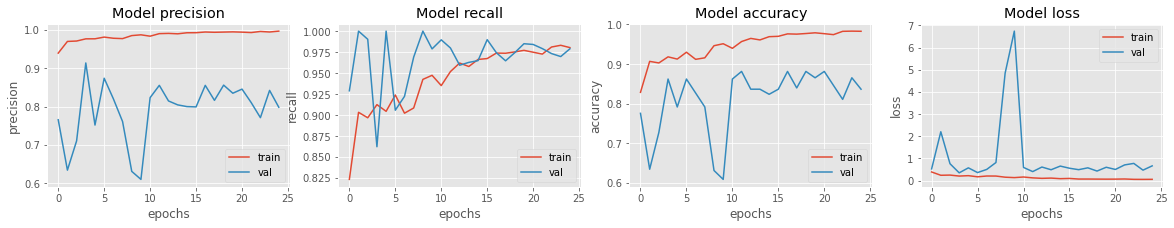

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(hist_aug.history[met])
    ax[i].plot(hist_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

==> It's clear that the model had a harder time learning from the augmented dataset. it's learning to generalize.

##Performance comparition on training sets

Compare models (without and with data augmentation)

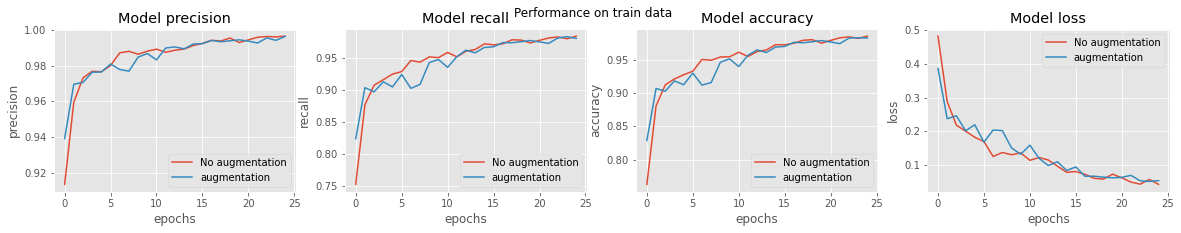

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
fig.suptitle("Performance on train data")
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(hist.history[ met])
    ax[i].plot(hist_aug.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['No augmentation', 'augmentation'])


For the train data, both models for augmented and non augmented data almost converge to the same performances. That's quite normal because we want the data augmentation to help the model generalize on validation set and not on train set.

##Performance comparition on validation sets

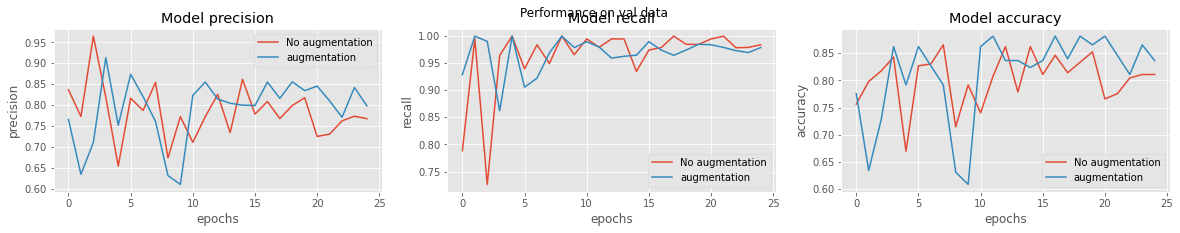

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
ax = ax.ravel()
fig.suptitle("Performance on val data")
for i, met in enumerate(['precision', 'recall', 'accuracy']):
    ax[i].plot(hist.history['val_' + met])
    ax[i].plot(hist_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['No augmentation', 'augmentation'])


=> We gain in both precision and accuracy but we lose in the recall. In our case, it's more important for us to to know if the person is really suffring from pneumonia. Thus, It's dangerous to consider a patient as a positive while he is not. By gaining in precision = $\frac{TP}{TP + FP}$, we have minimized this risk.   
\
Recall is also important as it indicates to which extent the model predicts all the positive cases: Recall= $\frac{TP}{TP + FN}$.

It's true that recall has decreased very skightly; but we have gained a lot more in terms of precision.